### Salary prediction, episode II: make it actually work (4 points)

Your main task is to use some of the tricks you've learned on the network and analyze if you can improve __validation MAE__. Try __at least 3 options__ from the list below for a passing grade. Write a short report about what you have tried. More ideas = more bonus points.

__Please be serious:__ " plot learning curves in MAE/epoch, compare models based on optimal performance, test one change at a time. You know the drill :)

You can use either __pytorch__ or __tensorflow__ or any other framework (e.g. pure __keras__). Feel free to adapt the seminar code for your needs. For tensorflow version, consider `seminar_tf2.ipynb` as a starting point.


In [1]:
# < A whole lot of your code > - models, charts, analysis

In [2]:
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
os.chdir('drive/MyDrive/NLP/Lena_Voite_course/week02_classification')

In [5]:

data = pd.read_csv('./Train_rev1.zip', compression='zip', index_col=None)
data.head()

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName
0,12612628,Engineering Systems Analyst,Engineering Systems Analyst Dorking Surrey Sal...,"Dorking, Surrey, Surrey",Dorking,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk
1,12612830,Stress Engineer Glasgow,Stress Engineer Glasgow Salary **** to **** We...,"Glasgow, Scotland, Scotland",Glasgow,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 35000/annum 25-35K,30000,cv-library.co.uk
2,12612844,Modelling and simulation analyst,Mathematical Modeller / Simulation Analyst / O...,"Hampshire, South East, South East",Hampshire,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 40000/annum 20-40K,30000,cv-library.co.uk
3,12613049,Engineering Systems Analyst / Mathematical Mod...,Engineering Systems Analyst / Mathematical Mod...,"Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 30000/annum 25K-30K negotiable,27500,cv-library.co.uk
4,12613647,"Pioneer, Miser Engineering Systems Analyst","Pioneer, Miser Engineering Systems Analyst Do...","Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk


In [6]:
len(data)

244768

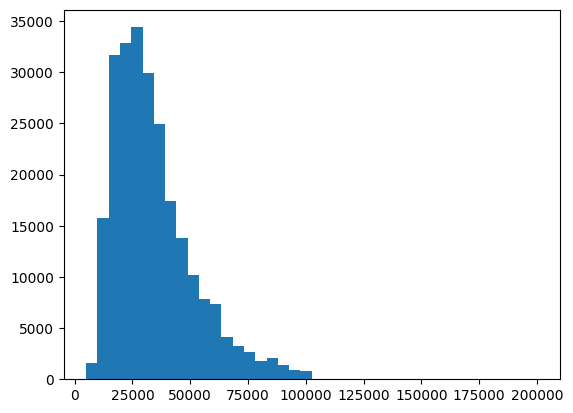

In [7]:
plt.hist(data['SalaryNormalized'], bins=40)
plt.show()

In [8]:
data['LogSalary1p'] = np.log1p(data['SalaryNormalized'])

In [9]:
text_cols = ['Title', 'FullDescription']
cat_cols = ["Category", "Company", "LocationNormalized", "ContractType", "ContractTime"]
target_col = "LogSalary1p"

data[cat_cols] = data[cat_cols].fillna('NaN')

In [10]:
import nltk
from string import punctuation as punct

tokenizer = nltk.tokenize.WordPunctTokenizer()

In [11]:
import gensim.downloader
embeddings = gensim.downloader.load('glove-wiki-gigaword-300')

[==================================================] 100.0% 376.1/376.1MB downloaded


In [12]:
from collections import Counter

In [13]:
tokenizer.tokenize('Hello, WORLD'.lower())

['hello', ',', 'world']

In [14]:
data[cat_cols].nunique()
companies, counts = zip(*Counter(data['Company']).most_common(1000))
companies = set(companies)
data['Company'] = data['Company'].apply(lambda company: company if company in companies else 'Other')

In [15]:
data['Company'].value_counts()

,count
Company,
Other,95650
NaN,32430
UKStaffsearch,4997
CVbrowser,2977
London4Jobs,2345
...,...
Oakland House Recruitment,40
BlueTownOnline.co.uk,40
SCC,40


In [16]:
from sklearn.feature_extraction import DictVectorizer

cat_vect = DictVectorizer(dtype=np.float32, sparse=False)
cat_vect.fit(data[cat_cols].apply(dict, axis=1))


DictVectorizer(dtype=<class 'numpy.float32'>, sparse=False)

In [17]:
np.unique(cat_vect.transform(data[cat_cols][:1000].apply(dict, axis=1)))

array([0., 1.], dtype=float32)

In [18]:
d = [{'col1': 1, 'col2': 2, 'col3': 'A'}, {'col1': 'C', 'col2': 10, 'col3': 1}]
a = DictVectorizer(dtype=np.float32, sparse=False).fit(d)
a.transform(d)

array([[ 1.,  0.,  2.,  0.,  1.],
       [ 0.,  1., 10.,  1.,  0.]], dtype=float32)

In [19]:
a.vocabulary_

{'col1': 0, 'col1=C': 1, 'col2': 2, 'col3': 3, 'col3=A': 4}

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim

In [21]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [22]:
data['Title'] = data['Title'].fillna('NaN')

In [23]:
words = ' '.join((data['Title'] + ' ' + data['FullDescription']))

In [24]:
tokens = list(tok for tok in tokenizer.tokenize(words.lower()) if tok not in punct)

In [25]:
c = Counter(tokens)
c.most_common(10)

[('and', 2657388),
 ('the', 2080994),
 ('to', 2019884),
 ('a', 1521925),
 ('of', 1426213),
 ('in', 1035792),
 ('for', 867233),
 ('with', 728884),
 ('you', 694177),
 ('****', 681869)]

In [26]:
tokens = set([tok for tok, cnt in c.items() if cnt > 10])
print(len(tokens))

32429


In [27]:
cnt = 0

In [65]:
def text_to_vector(sent):
    sent_tokens = tokenizer.tokenize(sent.lower())
    temp = np.array([ embeddings[tok] for tok in sent_tokens if tok in tokens and tok in embeddings])
    if len(temp.shape) == 1:
        temp = np.array([embeddings['unknown']])
    return np.sum(temp, axis=0)

In [124]:
def make_batch(data):
    batch = {}
    batch['Title'] = torch.tensor(np.stack(data['Title'].apply(text_to_vector).values)).float()
    batch['FullDescription'] = torch.tensor(np.stack(data['FullDescription'].apply(text_to_vector).values)).float()
    batch['Category'] = torch.tensor(cat_vect.transform(data[cat_cols].apply(dict, axis=1))).float()
    return batch, torch.tensor(data[target_col].to_numpy()).float()


In [69]:
a = torch.tensor(np.arange(20).reshape(4, 5)).to(dtype=torch.float32)
# kernel = nn.Parameter(torch.tensor([[[1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0]]], dtype=torch.float32))
conv = nn.Conv1d(in_channels=4, out_channels=6, kernel_size=3, bias=False)
print(conv.weight.shape)
conv(a)

torch.Size([6, 4, 3])


tensor([[-0.4827, -0.7604, -1.0380],
        [ 6.1122,  7.0680,  8.0239],
        [-4.3157, -4.7946, -5.2735],
        [-1.6517, -2.1796, -2.7076],
        [-5.9321, -6.8503, -7.7684],
        [-1.3049, -2.0030, -2.7012]], grad_fn=<SqueezeBackward1>)

In [32]:
pool = nn.AdaptiveMaxPool1d(2)
a = torch.tensor(np.arange(20).reshape(4, 5)).to(dtype=torch.float32)
pool(a)

tensor([[ 2.,  4.],
        [ 7.,  9.],
        [12., 14.],
        [17., 19.]])

In [33]:
np.concatenate([np.arange(6).reshape(2, 3), np.arange(6, 12).reshape(2, 3)], axis=1)

array([[ 0,  1,  2,  6,  7,  8],
       [ 3,  4,  5,  9, 10, 11]])

In [134]:
class SalaryPredictor(nn.Module):
    def __init__(self, n_cat_vocab=len(cat_vect.vocabulary_), hid_size=64, emb_size=300):
        super().__init__()

        # self.title_emb = nn.Embedding(n_tokens, emb_size)
        # self.title_conv = nn.Conv1d(emb_size, hid_size)
        # self.title_pool = nn.AdaptiveMaxPool1d(1)

        # self.desc_conv = nn.Conv1d(emb_size, hid_size)
        # self.desc_pool = nn.AdaptiveMaxPool1d(1)

        self.cat_seq = nn.Sequential(
            nn.Linear(n_cat_vocab, 2 * hid_size),
            nn.ReLU(),
            nn.Linear(2 * hid_size, hid_size)
        )

        self.pred = nn.Sequential(
            nn.Linear(2 * emb_size + hid_size, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, X):
        cat_x = self.cat_seq(X['Category'])
        X = torch.cat([X['Title'], X['FullDescription'], cat_x], dim=1)
        return self.pred(X)



In [179]:
lr = 3e-3
epochs = 3
batch_size = 512

model = SalaryPredictor().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()

In [92]:
def iterate_minibatches(data, batch_size, device):
    for idx in range(0, len(data), batch_size):
        batch = data.iloc[idx:idx+batch_size]
        X_batch, y_batch = make_batch(batch)
        for key, arr in X_batch.items():
            X_batch[key] = arr.to(device)
        yield X_batch, y_batch.to(device)

In [81]:
a = torch.randn(10, 3)
a = a.to(device)
a.device

device(type='cuda', index=0)

In [78]:
from tqdm import tqdm
from math import ceil

In [38]:
data_train, data_test = train_test_split(data, test_size=0.2, shuffle=True, random_state=42)

In [39]:
len(data_train), len(data_test)

(195814, 48954)

In [137]:
slc = 1000

In [151]:
# from tqdm import tqdm
# import math

# train_losses, test_losses = [], []
# for epoch in tqdm(range(epochs), desc="Epochs", position=0, leave=True):
#     model.train()
#     train_losses.append(0)
#     num_samples = 0
#     with tqdm(total=math.ceil(len(data_train[:slc]) / batch_size) + 1, desc=f"Training Epoch {epoch+1}", position=1, leave=True) as pbar_train:
#         for i, (X_batch, y_batch) in enumerate(iterate_minibatches(data_train[:slc], batch_size=batch_size, device=device)):
#             pred = model(X_batch)
#             loss = criterion(pred.squeeze(), y_batch)

#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()

#             train_losses[-1] += loss.item()
#             num_samples += len(X_batch)

#             pbar_train.update(1)
#     train_losses[-1] /= num_samples

#     model.eval()
#     test_losses.append(0)
#     num_samples = 0
#     with tqdm(total=math.ceil(len(data_test[:slc]) / batch_size), desc=f"Test Epoch {epoch+1}", position=1, leave=True) as pbar_val:
#         with torch.no_grad():
#             for i, (X_batch, y_batch) in enumerate(iterate_minibatches(data_test[:slc], batch_size=batch_size, device=device)):
#                 pred = model(X_batch)
#                 loss = criterion(pred.squeeze(), y_batch)

#                 test_losses[-1] += loss.item()
#                 num_samples += len(X_batch)

#                 pbar_val.update(1)
#     test_losses[-1] /= num_samples


Training Epoch 1:  89%|████████▉ | 8/9 [00:00<00:00, 13.58it/s]

Training Epoch 2:  89%|████████▉ | 8/9 [00:01<00:00,  7.85it/s]

Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.79s/it]


In [180]:
from tqdm import tqdm
from math import ceil

train_losses, test_losses = [], []
for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")

    model.train()
    train_loss = 0
    num_samples = 0
    with tqdm(total=ceil(len(data_train) / batch_size), desc="Training", leave=True) as pbar:
        for X_batch, y_batch in iterate_minibatches(data_train, batch_size=batch_size, device=device):
            pred = model(X_batch)
            loss = criterion(pred.squeeze(), y_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * len(y_batch)
            num_samples += len(y_batch)
            pbar.update(1)
    train_loss /= num_samples
    train_losses.append(train_loss)

    model.eval()
    test_loss = 0
    num_samples = 0
    with tqdm(total=ceil(len(data_test) / batch_size), desc="Testing", leave=True) as pbar:
        with torch.no_grad():
            for X_batch, y_batch in iterate_minibatches(data_test, batch_size=batch_size, device=device):
                pred = model(X_batch)
                loss = criterion(pred.squeeze(), y_batch)

                test_loss += loss.item() * len(y_batch)
                num_samples += len(y_batch)
                pbar.update(1)
    test_loss /= num_samples
    test_losses.append(test_loss)
    print(f"Training Loss: {train_loss:.4f}")
    print(f"Testing Loss: {test_loss:.4f}")
    print()


Epoch 1/3


Testing: 100%|██████████| 96/96 [00:30<00:00,  3.10it/s]


Training Loss: 20.5329
Testing Loss: 0.1376

Epoch 2/3


Testing: 100%|██████████| 96/96 [00:31<00:00,  3.04it/s]


Training Loss: 0.1364
Testing Loss: 0.1307

Epoch 3/3


Testing: 100%|██████████| 96/96 [00:30<00:00,  3.16it/s]

Training Loss: 0.1239
Testing Loss: 0.1106



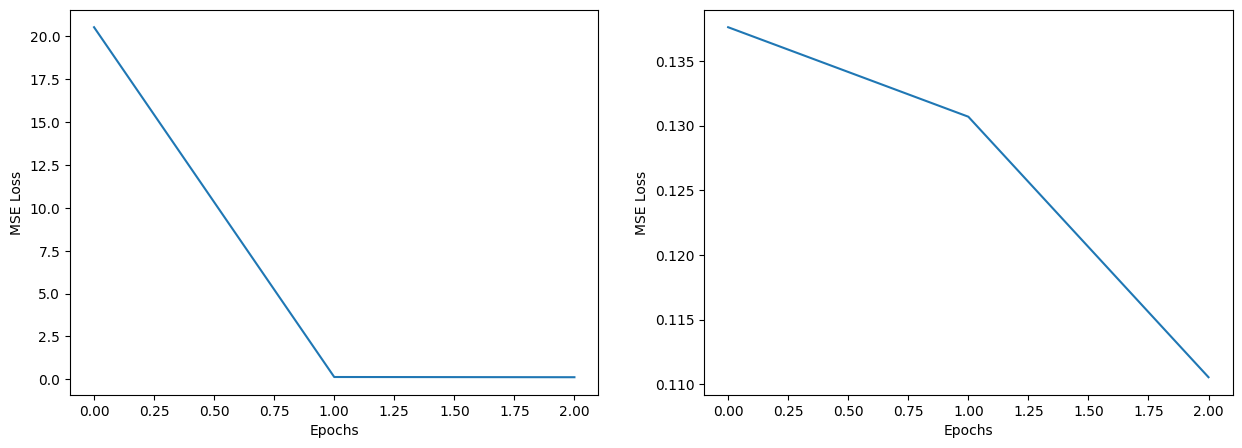

In [182]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].plot(train_losses, label='Train')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('MSE Loss')

axes[1].plot(test_losses, label='Test')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('MSE Loss')
plt.show()

### A short report

Please tell us what you did and how did it work.

`<YOUR_TEXT_HERE>`, i guess...

## Recommended options

#### A) CNN architecture

All the tricks you know about dense and convolutional neural networks apply here as well.
* Dropout. Nuff said.
* Batch Norm. This time it's `nn.BatchNorm*`/`L.BatchNormalization`
* Parallel convolution layers. The idea is that you apply several nn.Conv1d to the same embeddings and concatenate output channels.
* More layers, more neurons, ya know...


#### B) Play with pooling

There's more than one way to perform pooling:
* Max over time (independently for each feature)
* Average over time (excluding PAD)
* Softmax-pooling:
$$ out_{i, t} = \sum_t {h_{i,t} \cdot {{e ^ {h_{i, t}}} \over \sum_\tau e ^ {h_{j, \tau}} } }$$

* Attentive pooling
$$ out_{i, t} = \sum_t {h_{i,t} \cdot Attn(h_t)}$$

, where $$ Attn(h_t) = {{e ^ {NN_{attn}(h_t)}} \over \sum_\tau e ^ {NN_{attn}(h_\tau)}}  $$
and $NN_{attn}$ is a dense layer.

The optimal score is usually achieved by concatenating several different poolings, including several attentive pooling with different $NN_{attn}$ (aka multi-headed attention).

The catch is that keras layers do not inlude those toys. You will have to [write your own keras layer](https://keras.io/layers/writing-your-own-keras-layers/). Or use pure tensorflow, it might even be easier :)

#### C) Fun with words

It's not always a good idea to train embeddings from scratch. Here's a few tricks:

* Use a pre-trained embeddings from `gensim.downloader.load`. See last lecture.
* Start with pre-trained embeddings, then fine-tune them with gradient descent. You may or may not download pre-trained embeddings from [here](http://nlp.stanford.edu/data/glove.6B.zip) and follow this [manual](https://keras.io/examples/nlp/pretrained_word_embeddings/) to initialize your Keras embedding layer with downloaded weights.
* Use the same embedding matrix in title and desc vectorizer


#### D) Going recurrent

We've already learned that recurrent networks can do cool stuff in sequence modelling. Turns out, they're not useless for classification as well. With some tricks of course..

* Like convolutional layers, LSTM should be pooled into a fixed-size vector with some of the poolings.
* Since you know all the text in advance, use bidirectional RNN
  * Run one LSTM from left to right
  * Run another in parallel from right to left
  * Concatenate their output sequences along unit axis (dim=-1)

* It might be good idea to mix convolutions and recurrent layers differently for title and description


#### E) Optimizing seriously

* You don't necessarily need 100 epochs. Use early stopping. If you've never done this before, take a look at [early stopping callback(keras)](https://keras.io/callbacks/#earlystopping) or in [pytorch(lightning)](https://pytorch-lightning.readthedocs.io/en/latest/common/early_stopping.html).
  * In short, train until you notice that validation
  * Maintain the best-on-validation snapshot via `model.save(file_name)`
  * Plotting learning curves is usually a good idea
  
Good luck! And may the force be with you!